# Purpose

* Extend prototype 2 such that it works for unequal-mass binaries. 

As suggested by Hemanta, we'll use the `FINDCHIRP` algorithm. In particular, we will first compute the SNR for a 100Mpc source and fixed extrinsic parameters. Then, we will rescale the SNR using

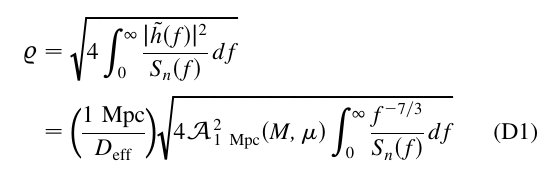

where

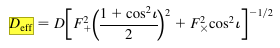

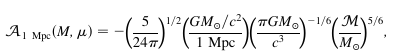

I.e.,

$$\rho \propto \frac{1}{D_{\rm eff}(\alpha,  \delta, \psi, t_{gps}, \iota, d_L)} \mathcal A_{\rm 1 \, Mpc}(M,\mu) f(M_{\rm total})$$

Here $\mathcal M=\mu^{3/5}/M^{2/5}=\eta^{3/5}M$ is the chirp mass, $M$ the total mass, $\mu=m_1 m_2/M$ the reduced mass, and symmetric mass ratio $\eta=\mu/M$.

In [1]:
from prototype02_cbcsnrs import CBCSNRsBase, compute_bilby_snr
import numpy as np
import pylab as plt

In [2]:
class BNSSNRInterpolator(CBCSNRsBase):
    def __init__(self, total_mass_min, total_mass_max, sampling_frequency=4096, waveform_arguments= dict(waveform_approximant = "TaylorF2", reference_frequency = 50., minimum_frequency = 10), list_of_detectors=["L1"]):
        # Set masses to be the same for now:
        nsamples = 100
        total_mass = np.geomspace(total_mass_min,  total_mass_max, nsamples)
        mass_1 = total_mass/2 # Equal mass in preliminary computation
        mass_2 = total_mass/2 # Equal mass in preliminary computation
        # Compute the inner products for each mass
        super().__init__(mass_1, mass_2, sampling_frequency, waveform_arguments, list_of_detectors)
        # Save values
        self.total_mass_min = total_mass_min
        self.total_mass_max = total_mass_max
        self.total_mass_table = total_mass
    def interpolate_inner_products_idx(self, total_mass):
        # Zeroth order approximation: Just return the inner product that is nearest to the correct mass value
        idx = np.searchsorted(self.total_mass_table, total_mass)
        return idx
    def single_detector_optimal_snr(self, mass_1, mass_2, luminosity_distance, theta_jn, ra, dec, psi, phase, geocent_time, ifo='L1'):
        ''' Single-detector optimal snr
        '''
        total_mass = mass_1+mass_2
        mu = mass_1*mass_2/total_mass
        chirp_mass = mu**(3./5.)/total_mass**(2/5)
        chirp_mass_unscaled = total_mass**(1./5.)/(2.*2**(1./5.)) # Assuming q=1
        iota = theta_jn
        indices = self.interpolate_inner_products_idx(total_mass) # Get the indices for the inner products
        Fp, Fc = self.fast_ifo_objects[ifo].antenna_pattern(ra, dec, psi, geocent_time)
        hp_inner_hp, hc_inner_hc = self.hp_inner_hp[ifo][indices], self.hc_inner_hc[ifo][indices]
        Deff1 = luminosity_distance/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
        Deff2 = 100/np.sqrt(Fp**2*((1+np.cos(0)**2)/2)**2+Fc**2*np.cos(0)**2 )
        A1 = chirp_mass**(5./6.)
        A2 = chirp_mass_unscaled**(5./6.)
        optimal_snr_squared_unscaled = Fp**2*hp_inner_hp + Fc**2*hc_inner_hc
        # Rescale:
        return (Deff2/Deff1)*(A1/A2)*np.sqrt(np.real(optimal_snr_squared_unscaled))
    def evaluate(self, mass_1, mass_2, luminosity_distance, theta_jn, ra, dec, psi, phase, geocent_time):
        return self.single_detector_optimal_snr(mass_1, mass_2, luminosity_distance, theta_jn, ra, dec, psi, phase, geocent_time, ifo='L1')
    def __call__(self, mass_1, mass_2, luminosity_distance, theta_jn, ra, dec, psi, phase, geocent_time):
        return self.evaluate(mass_1, mass_2, luminosity_distance, theta_jn, ra, dec, psi, phase, geocent_time)

In [3]:
q = 1 # Assume mass_1=mass_2
zmin, zmax = 0, 12
total_mass_min, total_mass_max = 0.83*(1+zmin), 2*3.2*(1+zmax) # Note: Redshifted masses
bns_snr_interpolator = BNSSNRInterpolator(total_mass_min, total_mass_max)

In [10]:
mass_1 = 12
mass_2 = mass_1
luminosity_distance = 3604
theta_jn = np.pi/10
ra, dec, psi, phase, geocent_time = np.pi/5, np.pi/8, np.pi/3, 3*np.pi/5, 182381.12
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0
optimal_snrs = bns_snr_interpolator(mass_1, mass_2, luminosity_distance, theta_jn, ra, dec, psi, phase, geocent_time)
optimal_snrs

5.275394502360717

In [11]:
compute_bilby_snr(mass_1, mass_2, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, luminosity_distance, theta_jn, psi, phase, geocent_time, ra, dec, duration=128, sampling_frequency=4096, waveform_arguments= dict(waveform_approximant = "TaylorF2", reference_frequency = 50., minimum_frequency = 10), list_of_detectors=["L1"])

5.125552699346134

## Test  1

Now how well this works over a wide range of values

In [12]:
bilby_snrs = []
bilby_snrs2 = []
interpolated_snrs = []
nsamples = 40
masses = np.linspace(1,13,nsamples)
for i in range(nsamples):
    np.random.seed(i)
    mass_1 = masses[i]
    mass_2 = mass_1
    # Fix luminosity distance
    luminosity_distance = 80
    # Randomly sample everything else:
    theta_jn = np.random.uniform(0,2*np.pi)
    ra, dec, psi, phase, geocent_time = np.random.uniform(0,2*np.pi), np.random.uniform(0,np.pi), np.random.uniform(0,2*np.pi), np.random.uniform(0,2*np.pi), np.random.uniform(12933,1529132)
    a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin
    # Compute bilby snr first (verified/reviewed)
    bilby_snr = compute_bilby_snr(mass_1, mass_2, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, luminosity_distance, theta_jn, psi, phase, geocent_time, ra, dec, duration=128*4, sampling_frequency=4096, waveform_arguments= dict(waveform_approximant = "TaylorF2", reference_frequency = 50., minimum_frequency = 10), list_of_detectors=["L1"])
    bilby_snrs.append(bilby_snr)
    bilby_snr2 = compute_bilby_snr(mass_1, mass_2, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, luminosity_distance, 0, psi, phase, geocent_time, ra, dec, duration=128*4, sampling_frequency=4096, waveform_arguments= dict(waveform_approximant = "TaylorF2", reference_frequency = 50., minimum_frequency = 10), list_of_detectors=["L1"])
    bilby_snrs2.append(bilby_snr2)
    # Compute the interpolated snr
    interpolated_snr = bns_snr_interpolator(mass_1, mass_2, luminosity_distance, theta_jn, ra, dec, psi, phase, geocent_time)
    interpolated_snrs.append(interpolated_snr)

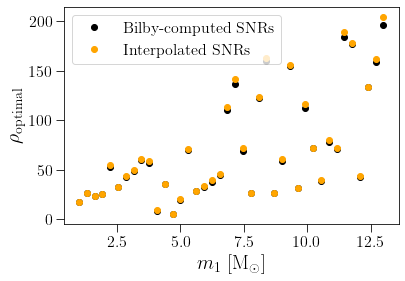

In [13]:
bilby_snrs = np.array(bilby_snrs)
bilby_snrs2 = np.array(bilby_snrs2)
interpolated_snrs = np.array(interpolated_snrs)
plt.plot(masses, bilby_snrs, 'o', color='black', label='Bilby-computed SNRs')
plt.plot(masses, interpolated_snrs, 'o', color='orange', label='Interpolated SNRs')
plt.xlabel(r"$m_1$ [$\rm M_\odot$]")
plt.ylabel(r"$\rho_{\rm optimal}$")
plt.legend()
plt.show()

# Test 2

* Does the code work with arrays and with fast numpy computation?

1. Create an array of ra, dec, masses, etc
2. Evaluate SNR
3. Plot SNR
4. Compare with the iterative for-loop approach
5. Plot the comparison

In [14]:
# STEP 1
nsamples = 40
masses = np.linspace(1,13,nsamples)
np.random.seed(0)
mass_1 = masses
mass_2 = mass_1
# Fix luminosity distance
luminosity_distance = 80
# Randomly sample everything else:
theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
ra, dec, psi, phase, geocent_time = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(12933,1529132, size=nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [15]:
# STEP 2
# Compute the interpolated snr
interpolated_snrs = bns_snr_interpolator(mass_1, mass_2, luminosity_distance, theta_jn, ra, dec, psi, phase, geocent_time)

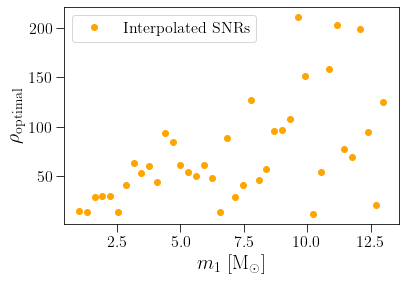

In [16]:
# STEP 3: Plot SNRs
plt.plot(masses, interpolated_snrs, 'o', color='orange', label='Interpolated SNRs')
plt.xlabel(r"$m_1$ [$\rm M_\odot$]")
plt.ylabel(r"$\rho_{\rm optimal}$")
plt.legend()
plt.show()

In [17]:
# STEP 4: Compare with the for loop approach + Bilby
bilby_snrs = []
for i in range(nsamples):
    # Compute bilby snr first (verified/reviewed)
    bilby_snr = compute_bilby_snr(mass_1[i], mass_2[i], a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, luminosity_distance, theta_jn[i], psi[i], phase[i], geocent_time[i], ra[i], dec[i], duration=128*4, sampling_frequency=4096, waveform_arguments= dict(waveform_approximant = "TaylorF2", reference_frequency = 50., minimum_frequency = 10), list_of_detectors=["L1"])
    bilby_snrs.append(bilby_snr)
bilby_snrs = np.array(bilby_snrs)

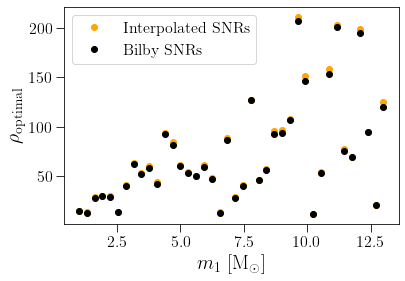

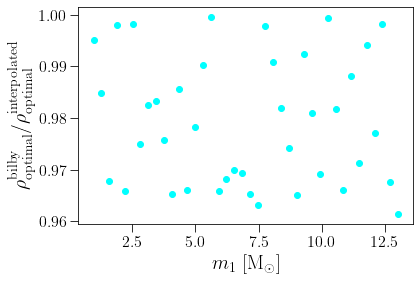

Around ~3% error at most


In [18]:
# STEP 5: Compare the SNRs
plt.plot(masses, interpolated_snrs, 'o', color='orange', label='Interpolated SNRs')
plt.plot(masses, bilby_snrs, 'o', color='black', label='Bilby SNRs')
plt.xlabel(r"$m_1$ [$\rm M_\odot$]")
plt.ylabel(r"$\rho_{\rm optimal}$")
plt.legend()
plt.show()
# Plot the relative difference
plt.plot(masses, bilby_snrs/interpolated_snrs, 'o', color='cyan')
plt.xlabel(r"$m_1$ [$\rm M_\odot$]")
plt.ylabel(r"$\rho_{\rm optimal}^{\rm bilby}/\rho_{\rm optimal}^{\rm interpolated}$")
plt.show()
print("Around ~3% error at most")

# Test 3

* How well does the scheme work if we use the IMRPhenomXPHM waveform instead of TaylorF2?
* Re-do the above but with IMRPhenomXPHM
* Does the SNR computation still hold for unequal mass binaries?

In [32]:
bns_snr_interpolator = BNSSNRInterpolator(1.8, 14*2, sampling_frequency=4096, waveform_arguments= dict(waveform_approximant = "IMRPhenomXPHM", reference_frequency = 50., minimum_frequency = 10), list_of_detectors=["L1"])

In [33]:
# STEP 1 compute the SNRs
nsamples = 20
masses = np.linspace(2,13,nsamples)
np.random.seed(0)
mass_1 = masses
q = np.random.uniform(0.2,1,size=nsamples)
mass_2 = mass_1*q
total_mass = mass_1+mass_2
# Fix luminosity distance
luminosity_distance = 80
# Randomly sample everything else:
theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
ra, dec, psi, phase, geocent_time = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(12933,1529132, size=nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin
interpolated_snrs = bns_snr_interpolator(mass_1, mass_2, luminosity_distance, theta_jn, ra, dec, psi, phase, geocent_time)

In [34]:
bilby_snrs = []
for i in range(nsamples):
    # Compute bilby snr first (verified/reviewed)
    bilby_snr = compute_bilby_snr(mass_1[i], mass_2[i], a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, luminosity_distance, theta_jn[i], psi[i], phase[i], geocent_time[i], ra[i], dec[i], duration=128*4, sampling_frequency=4096, waveform_arguments= dict(waveform_approximant = "IMRPhenomXPHM", reference_frequency = 50., minimum_frequency = 10), list_of_detectors=["L1"])
    bilby_snrs.append(bilby_snr)
bilby_snrs = np.array(bilby_snrs)

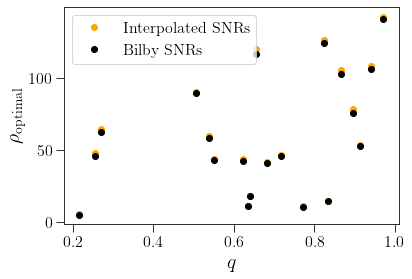

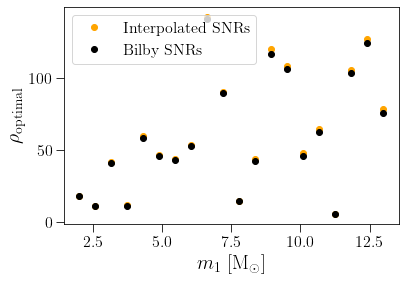

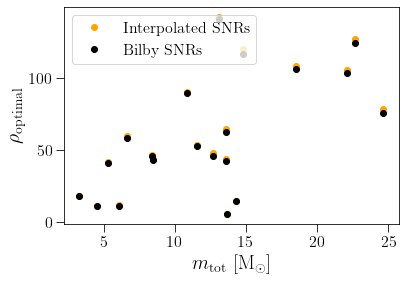

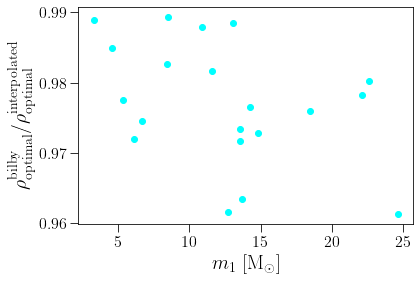

In [35]:
# Compare the SNRs
# STEP 3: Compare the SNRs
plt.plot(q, interpolated_snrs, 'o', color='orange', label='Interpolated SNRs')
plt.plot(q, bilby_snrs, 'o', color='black', label='Bilby SNRs')
plt.xlabel(r"$q$")
plt.ylabel(r"$\rho_{\rm optimal}$")
plt.legend()
plt.show()
plt.plot(mass_1, interpolated_snrs, 'o', color='orange', label='Interpolated SNRs')
plt.plot(mass_1, bilby_snrs, 'o', color='black', label='Bilby SNRs')
plt.xlabel(r"$m_1$ [$\rm M_\odot$]")
plt.ylabel(r"$\rho_{\rm optimal}$")
plt.legend()
plt.show()
plt.plot(total_mass, interpolated_snrs, 'o', color='orange', label='Interpolated SNRs')
plt.plot(total_mass, bilby_snrs, 'o', color='black', label='Bilby SNRs')
plt.xlabel(r"$m_{\rm tot}$ [$\rm M_\odot$]")
plt.ylabel(r"$\rho_{\rm optimal}$")
plt.legend()
plt.show()
# Plot the relative difference
plt.plot(total_mass, bilby_snrs/interpolated_snrs, 'o', color='cyan')
plt.xlabel(r"$m_1$ [$\rm M_\odot$]")
plt.ylabel(r"$\rho_{\rm optimal}^{\rm bilby}/\rho_{\rm optimal}^{\rm interpolated}$")
plt.show()

**Conclusion:** The code does works reasonably well with IMRPhenomXPHM, with around 4% error.

# Test 4

* Does the code work for unequal mass binaries for the TaylorF2 waveform?
* Re-run the above test with TaylorF2

In [36]:
bns_snr_interpolator = BNSSNRInterpolator(0.83, 14*2, sampling_frequency=4096, waveform_arguments= dict(waveform_approximant = "TaylorF2", reference_frequency = 50., minimum_frequency = 10), list_of_detectors=["L1"])

In [37]:
# STEP 1 compute the SNRs
nsamples = 30
masses = np.linspace(1,13,nsamples)
np.random.seed(0)
mass_1 = masses
q = np.random.uniform(0.2,1,size=nsamples)
mass_2 = mass_1*q
total_mass = mass_1+mass_2
# Fix luminosity distance
luminosity_distance = 80
# Randomly sample everything else:
theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
ra, dec, psi, phase, geocent_time = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(12933,1529132, size=nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin
interpolated_snrs = bns_snr_interpolator(mass_1, mass_2, luminosity_distance, theta_jn, ra, dec, psi, phase, geocent_time)

In [38]:
bilby_snrs = []
for i in range(nsamples):
    # Compute bilby snr first (verified/reviewed)
    bilby_snr = compute_bilby_snr(mass_1[i], mass_2[i], a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, luminosity_distance, theta_jn[i], psi[i], phase[i], geocent_time[i], ra[i], dec[i], duration=128*4, sampling_frequency=4096, waveform_arguments= dict(waveform_approximant = "TaylorF2", reference_frequency = 50., minimum_frequency = 10), list_of_detectors=["L1"])
    bilby_snrs.append(bilby_snr)
bilby_snrs = np.array(bilby_snrs)

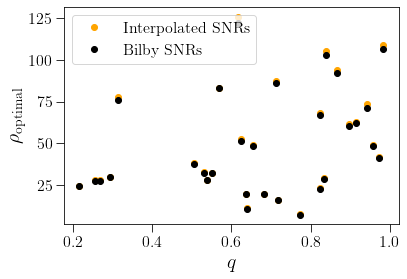

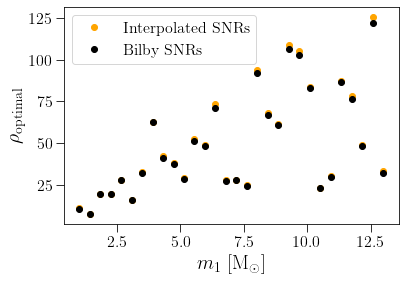

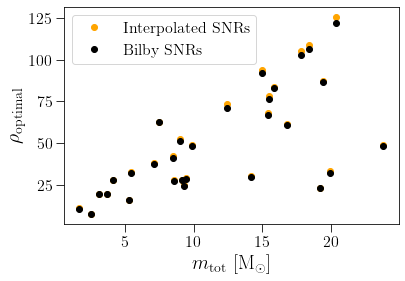

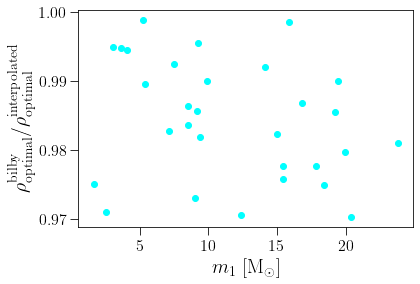

In [39]:
# Compare the SNRs
# STEP 3: Compare the SNRs
plt.plot(q, interpolated_snrs, 'o', color='orange', label='Interpolated SNRs')
plt.plot(q, bilby_snrs, 'o', color='black', label='Bilby SNRs')
plt.xlabel(r"$q$")
plt.ylabel(r"$\rho_{\rm optimal}$")
plt.legend()
plt.show()
plt.plot(mass_1, interpolated_snrs, 'o', color='orange', label='Interpolated SNRs')
plt.plot(mass_1, bilby_snrs, 'o', color='black', label='Bilby SNRs')
plt.xlabel(r"$m_1$ [$\rm M_\odot$]")
plt.ylabel(r"$\rho_{\rm optimal}$")
plt.legend()
plt.show()
plt.plot(total_mass, interpolated_snrs, 'o', color='orange', label='Interpolated SNRs')
plt.plot(total_mass, bilby_snrs, 'o', color='black', label='Bilby SNRs')
plt.xlabel(r"$m_{\rm tot}$ [$\rm M_\odot$]")
plt.ylabel(r"$\rho_{\rm optimal}$")
plt.legend()
plt.show()
# Plot the relative difference
plt.plot(total_mass, bilby_snrs/interpolated_snrs, 'o', color='cyan')
plt.xlabel(r"$m_1$ [$\rm M_\odot$]")
plt.ylabel(r"$\rho_{\rm optimal}^{\rm bilby}/\rho_{\rm optimal}^{\rm interpolated}$")
plt.show()

# Test 5

* How fast is the code?
* Run the code on 1e6 samples and time it

In [40]:
nsamples = int(1e6)
masses = np.linspace(2,13,nsamples)
np.random.seed(0)
mass_1 = masses
mass_2 = mass_1
# Fix luminosity distance
luminosity_distance = 80
# Randomly sample everything else:
theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
ra, dec, psi, phase, geocent_time = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(12933,1529132, size=nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin
%timeit interpolated_snrs = bns_snr_interpolator(mass_1, mass_2, luminosity_distance, theta_jn, ra, dec, psi, phase, geocent_time)

4.42 s ± 614 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Conclusion:** Takes at 4-5 seconds to run on a million samples. This is sufficiently fast.

# Conclusion

* The code works reasonably fast and also performs well with unequal mass binaries.
* The code works with `IMRPhenomXPHM` waveform in the high-mass regime, but seemingly breaks down in the low-mass regime. Is this because the IMRPhenomXPHM waveform is not supported in the low-mass regime?
* The interpolation class has been moved to `prototype04_cbcsnrs.py` and it replaces the class assuming a special case (equal mass BNS)